# Trabajo Práctico 5 - Grupo 1

* Ian Cruz Diaz
* Martin Sebastian Rodriguez Turco
* Agustin Galdeman


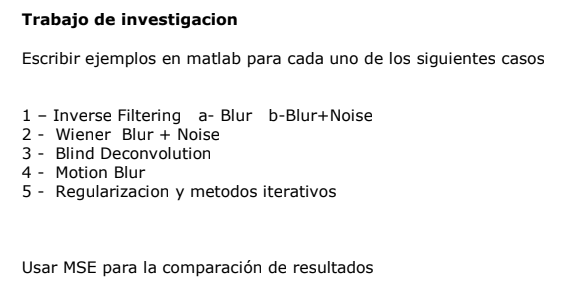

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Inverse Filtering

In [2]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2,fftshift,ifft2,ifftshift
from scipy import signal

def fft_c(x):
  """FFT + FFT SHIFT
  """
  return fftshift(fft2(x))

def ifft_c(x):
  return ifft2(ifftshift(x))

def get_gaussian_kernel(size,sigma):
  """Funcion que devuelve un kernel gaussiano segun el tamaño y el desvío 
  especificado

  Args:
    size: Tamaño del kernel
    sigma: Desvío estandar
  
  Returns: Un kernel de tamaño (size,size) normalizado
  """
  kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * \
                           math.e**((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))\
                                    /(2*sigma**2)), (size, size))
  kernel /= np.sum(kernel)
  return kernel

def get_delta(img):
  """Función que devuelve una matriz delta del tamaño de la imagen especificada

  Args:
    img: Matriz sobre la cual se extraerá su tamaño
  """
  delta = np.zeros_like(img).astype(np.float64)
  delta[delta.shape[0]//2,delta.shape[1]//2] = 1.0
  return delta

def get_expanded_kernel(img,kernel):
  """Funcion que expande un kernel al tamaño de una imagen dada

  Args:
    img: Imagen sobre la cual se extraera su tamaño para expndir el kernel al 
      mismo
    kernel: Kernel original que se buscara expandir
  """
  conv = cv2.filter2D(src=get_delta(img), kernel=kernel, ddepth=-1)
  conv /= np.sum(conv)
  return conv

def add_noise_to_image(img,mean,std):
  """Funcion que agrega ruido normal a una imagen dada
  """
  noise = np.random.normal(mean, std, img.shape)
  noisy_img = img + noise
  noisy_img_clipped = np.clip(noisy_img, -0.5, 0.5)
  return noisy_img_clipped,noise

def productoftransfersinfreqdom(img,kernel):
  """Convolucion entre una imagen y un kernel mediante el producto de sus FFTs

  Args:
    img: imagen a convolucionar
    kernel: Kernel con el cual se aplicara la convolucion
  """
  true_kernel = get_expanded_kernel(img,kernel)
  product = fft_c(img)*fft_c(true_kernel)
  return np.real(ifftshift(ifft_c(product)))
    
def restoreByInverseFilter(degraded,kernel):
  """Funcion que aplica el filtro inverso a una imagen a partir del kernel
  """
  expanded_kernel = get_expanded_kernel(degraded,kernel)
  #print(f"Type Expanded kernel: {expanded_kernel.shape} - \
  #{type(expanded_kernel[0][0])} - MAX= {expanded_kernel.max()} - MIN= {expanded_kernel.min()}")
  K = fft2(expanded_kernel)
  #print(f"Type K: {K.shape} - {type(K[0][0])} - MAX= {np.abs(K).max()} - \
  #MIN= {np.abs(K).min()} - MEAN= {np.mean(np.abs(K))}")

  # I = original(f), K = kernel(f), G = degraded(f)
  G = fft2(degraded)
  #print(f"Type G: {G.shape} - {type(G[0][0])} - MAX= {np.abs(G).max()} - \
  #MIN= {np.abs(G).min()} - MEAN= {np.mean(np.abs(G))}")

  I_c = fftshift(G/K)
  #print(f"Type I: {I_c.shape} - {type(I_c[0][0])} - MAX= {np.abs(I_c).max()} -\
  # MIN= {np.abs(I_c).min()} - MEAN= {np.mean(np.abs(I_c))}")

  # G= I*K <=> I=G/K
  return np.real(ifftshift(ifft_c(I_c)))
  
def modsquaredF(x):
  return np.square(np.abs(fft2(x)))

def modsquare(x):
  return np.square(np.abs(x))

def restoreByWiener(original,degraded,kernel,noise):
  """Funcion que aplica el filtro inverso mediante Wiener
  """
  h = get_expanded_kernel(original,kernel) 
  H = fft2(h)
  G = fft2(degraded)
  S_n = modsquaredF(noise)
  S_f = modsquaredF(original)
  W = np.conj(H)/( modsquare(H)+ S_n/S_f)
  F_hat_c = fftshift(W*G)
  f = np.real(fftshift(ifft_c(F_hat_c)))
  return f

def plot_images(original,txt1,degraded,txt2,restored,txt3):
  """Funcion para plotear 3 imagenes al mismo tiempo
  """
  fig=plt.figure(figsize=(14, 10))
  fig.add_subplot(1, 3, 1)
  plt.title(txt1)
  plt.imshow(original,cmap='gray')
  fig.add_subplot(1, 3, 2)
  plt.title(txt2)
  plt.imshow(degraded,cmap='gray')
  fig.add_subplot(1, 3, 3)
  plt.title(txt3)
  plt.imshow(restored,cmap='gray')

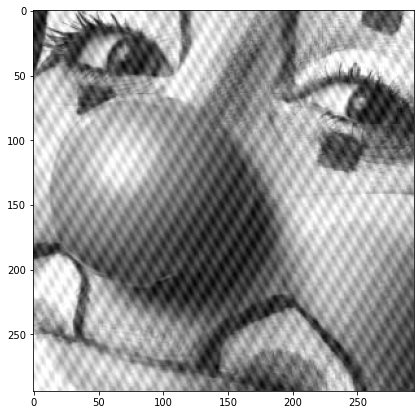

In [3]:
clown = cv2.imread('/content/drive/Shareddrives/Imagenes/TP5/clown.jpg')
bw_clown = cv2.cvtColor(clown,cv2.COLOR_BGR2GRAY)
bw_clown = np.array(bw_clown)/255.0 - 0.5
plt.figure(figsize=(7,7))
plt.imshow(bw_clown,cmap='gray')
plt.show()

### Blur

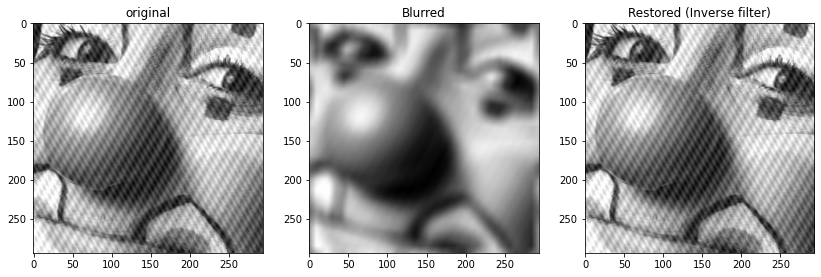

In [4]:
kernel_test = get_gaussian_kernel(size=19,sigma=20)

original = bw_clown.copy()

blurred = productoftransfersinfreqdom(original,kernel_test)

restored = restoreByInverseFilter(blurred,kernel_test)

plot_images(original,"original",blurred,"Blurred",restored,"Restored (Inverse filter)")

### Blur + Noise

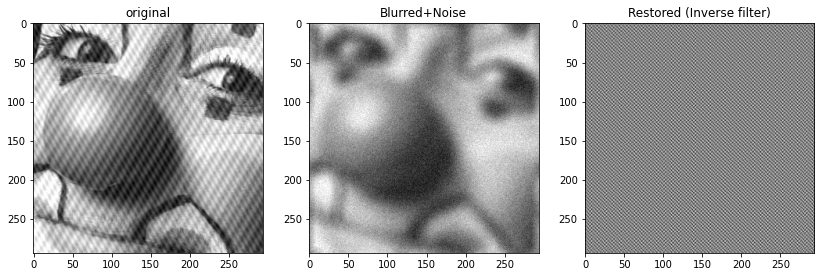

In [5]:
original = bw_clown.copy()

blurred = productoftransfersinfreqdom(original,kernel_test)

blurred_noise, _ = add_noise_to_image(blurred, 0,5e-2)

restored = restoreByInverseFilter(blurred_noise,kernel_test)

plot_images(original,"original",blurred_noise,"Blurred+Noise",restored,"Restored (Inverse filter)")

Como se puede observar, al agregarle ruido a la imagen con blur e intentar aplicar el filtro inverso, el resultado no es el deseado. Esto se debe a las propiedades de la deconvolucion mediante la FFT. Como bien sabemos, el proceso de *Blur* remueve las altas frecuencias de una imagen, este es su propósito. Por esta razon es que las altas frecuencias tienden a **cero**, esto significa a su vez, que las altas frecuencias del kernel K tambien deben tender a cero. Como resultado de esto, si aplicamos ruido blanco, como es el caso anterior, este tendra valores de frecuencia altas, los cuales, seran divididos por valores cercanos a cero. Esto consecuentemente, produce que la imagen de salida diverga a valores demasiado altos, y es por eso que se genera el resultado de salida que se ve arriba.
Para mas informacion sobre el tema, dejo un [comentario en StackOverflow](https://stackoverflow.com/questions/53743561/deblurring-an-image) que lo explica en detalle.



### Wiener Filter

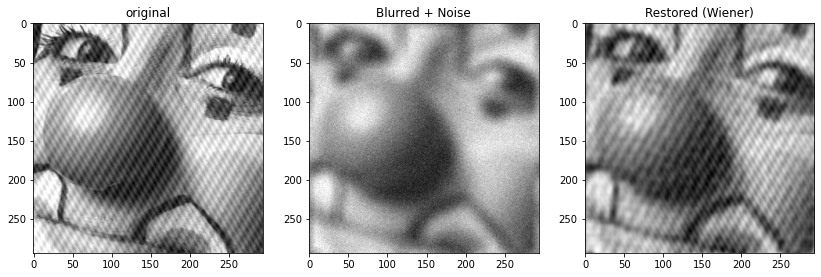

In [6]:
restored_wienier = restoreByWiener(original,blurred_noise,kernel_test,_)
plot_images(original,"original",blurred_noise,"Blurred + Noise",restored_wienier,"Restored (Wiener)")

Como se puede observar, mediante el método de Wiener se pudo resolver la dificultad que sugía de intentar obtener la imagen mediante la inversión del filtro.

### Blind Deconvolution

In [7]:
def richardson_lucy(image, psf, iterations=50, clip=True, filter_epsilon=None):
    """https://github.com/scikit-image/scikit-image/blob/master/skimage/restoration/deconvolution.py#L329-L385"""

    float_type = np.promote_types(image.dtype, np.float32)
    image = image.astype(float_type, copy=False)
    psf = psf.astype(float_type, copy=False)
    im_deconv = np.full(image.shape, 0.5, dtype=float_type)
    psf_mirror = np.flip(psf)

    for _ in range(iterations):
        conv = signal.convolve(im_deconv, psf, mode='same')
        if filter_epsilon:
            relative_blur = np.where(conv < filter_epsilon, 0, image / conv)
        else:
            relative_blur = image / conv
        im_deconv *= signal.convolve(relative_blur, psf_mirror, mode='same')

    if clip:
        im_deconv[im_deconv > 1] = 1
        im_deconv[im_deconv < -1] = -1

    return im_deconv

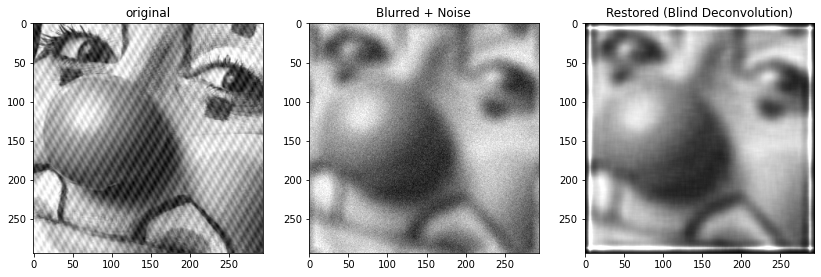

In [8]:
k_size = (13, 13)
kernel = np.full(k_size, 1/k_size[0])

image_deconv = richardson_lucy((np.clip(blurred_noise,-0.5,0.5)+0.5), kernel, iterations=5)


plot_images(original,"original",blurred_noise,"Blurred + Noise",image_deconv,"Restored (Blind Deconvolution)")

Como se puede apreciar, el metodo de richardson_lucy, tambien es útil a la hora de resolver el problema

### Motion Blur Filter

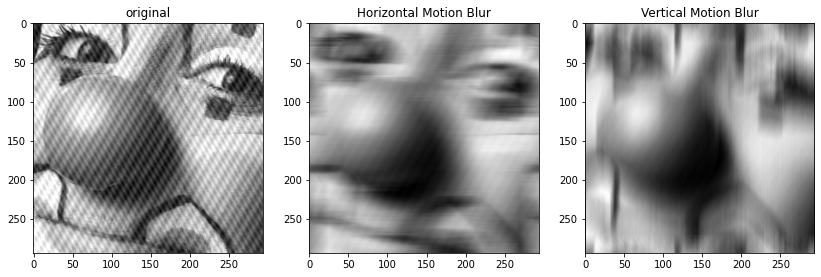

In [9]:
# Specify the kernel size.
# The greater the size, the more the motion.
kernel_size = 50
  
# Create the vertical kernel.
kernel_v = np.zeros((kernel_size, kernel_size))
  
# Create a copy of the same for creating the horizontal kernel.
kernel_h = np.copy(kernel_v)
  
# Fill the middle row with ones.
kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
  
# Normalize.
kernel_v /= kernel_size
kernel_h /= kernel_size

motion_blur_h = productoftransfersinfreqdom(original,kernel_h)
motion_blur_v = productoftransfersinfreqdom(original,kernel_v)

plot_images(original,"original",motion_blur_h,"Horizontal Motion Blur",motion_blur_v,"Vertical Motion Blur")

### Regularization

In [10]:
def stochastic_regularization(img, degraded_img, psf, noise):
  psf_f = np.fft.fft2(np.fft.ifftshift(psf))

  Y = np.fft.fft2(degraded_img)

  noise_power = np.absolute(np.fft.fft2(np.corrcoef(noise)))
  img_power = np.absolute(np.fft.fft2(np.corrcoef(img)))

  restored_img = np.absolute(
    np.fft.ifft2((img_power * np.conj(psf_f))* Y\
          / (img_power * psf_f * np.conj(psf_f) + noise_power))
  )

  return restored_img

def kernel_to_psf(img, kernel):
  """Recibe una imagen y un kernel y devuelve la psf con 0 padding y el tamaño 
  de la imagen
  """

  img_height, img_width = img.shape
  kernel_height, kernel_width = kernel.shape
  pad_height = int((img_height - kernel_height) / 2)
  pad_width = int((img_width - kernel_width) / 2)

  psf = np.pad(kernel, ((pad_height, pad_height), (pad_width, pad_width)),\
               'constant')

  return psf
  
def make_1s_kernel(size, norm=True):
  """Realiza una matriz de 1's con el tamaño requerido"""

  kernel = np.ones((size, size)).astype(np.float64)
  if norm:
    kernel /= size**2
  return kernel

def blurr_image_in_freq_domain(img, psf):
  """ Recibe la PSF, no el kernel!
  """

  PSF_F = np.fft.fft2(np.fft.ifftshift(psf))
  IMG_F = np.fft.fft2(img)
  return np.absolute(np.fft.ifft2((PSF_F * IMG_F))).astype(np.float64)

def add_gaussian_noise(img, SNR=10):
  """Agrega ruido gaussiano a la imagen"""
  row, col = img.shape
  std =  img.std()
  sigma_noise=np.sqrt((std**2) * 10**(-SNR / 10))
  noise = np.random.normal(0, sigma_noise, (row, col))
  noise = noise.reshape(row, col)
  return img + noise, noise



def mse(original_hat, original):
  error = original_hat - original
  return np.mean(np.square(error))

def nmse(original, procesada):
  var_erro = (np.std(original - procesada))**2
  var_orig = (np.std(original))**2
  norm_mse = 100 * (var_erro / var_orig)
  return norm_mse 


original = (original + 0.5)*255

In [11]:
blur_ksize = 10

kernel = make_1s_kernel(blur_ksize)

psf = kernel_to_psf(original, kernel)

blurr_img = blurr_image_in_freq_domain(original, psf)

blurr_img_with_noise, noise = add_gaussian_noise(blurr_img)

restored_image = stochastic_regularization(original, blurr_img_with_noise, psf, noise)

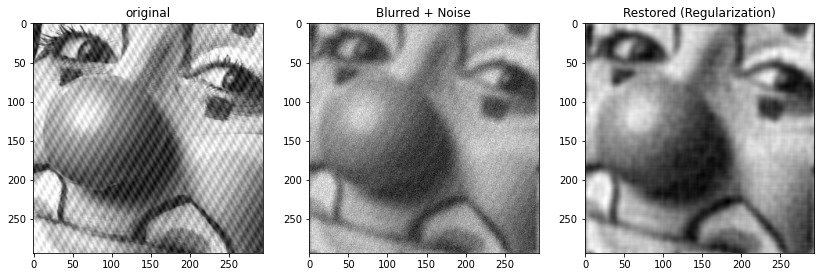

In [12]:
plot_images(original,"original",blurr_img_with_noise,"Blurred + Noise",restored_image,"Restored (Regularization)")

In [13]:
DMSE = mse(blurr_img_with_noise, original)
print("DMSE = ", DMSE)

RMSE = mse(restored_image, original)
print("RMSE = ", RMSE)

DMSE =  762.2170625340581
RMSE =  465.6056270110466


### Método Iterativo

In [14]:
from scipy import linalg

def doubleCirculant(mat,sh):
    original_shape = mat.shape
    
    padded = np.zeros(sh)
    padded[0:original_shape[0],0:original_shape[1]] = mat
    
    circulants = np.zeros((sh[0],sh[1],sh[1]))
    for i,v in enumerate(padded):
        aux = np.zeros(sh[1])
        aux[0] = v[0]
        circulants[i] = linalg.toeplitz(v,aux)

    totalSize = sh[0] * sh[1]
    final = np.zeros((totalSize,totalSize))
    for j in range(sh[0]):
        for i,mat in enumerate(circulants):
            x,y = mat.shape
            if( (i+j) < (x-1)):
                final[(i+j)*x:(i+j+1)*x,(j)*y:(j+1)*y] = mat
                
    return final

def normalize(img):
    mini = np.min(img)
    imgN = img - np.sign(mini)*np.abs(mini)
    imgN = imgN/np.max(imgN)
    return imgN

def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

El MSE contra la imagen blurreada y con ruido aditivo es: 0.02474258995506235


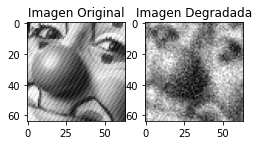

In [15]:
original = cv2.resize(original,(64,64))
original = normalize(original)
row,col= original.shape

#Definimos los filtros de blurring y high pass para la regularizacion
C=np.zeros((col,row))
Csmall=np.array([[0,-0.25,0],[-0.25, 1, -0.25],[0,-0.25,0]])
nb = C.shape[0]
na = Csmall.shape[0]
lower = (nb) // 2 - (na // 2)
upper = (nb // 2) + (na // 2)+1
C[lower:upper, lower:upper] = Csmall

blurr_size = 5
H=np.zeros(original.shape)
lpass=np.ones((blurr_size,blurr_size))/blurr_size**2
nb = H.shape[0]
lower = (nb) // 2 - (blurr_size // 2)
upper = (nb // 2) + (blurr_size // 2)+1
H[lower:upper, lower:upper] = lpass

#Calculamos las matrices block circulant
C_double = doubleCirculant(Csmall,original.shape)
H_double = doubleCirculant(lpass,original.shape)
#print(H_double, C_double)

#Degradamos la imagen
HLP = np.fft.fft2(np.fft.ifftshift(H))
f = np.fft.fft2(original)
imgLP = np.abs(np.fft.ifft2(np.multiply(f,HLP)))

noise =  np.random.normal(loc=0, scale=0.1, size=original.shape)
g = imgLP + noise
g_flatten = g.flatten().reshape(row*col,1)


#Muestro las imagenes
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Imagen Original")
ax1.imshow(original*255, cmap='gray', vmin=0, vmax=255)
ax2 = fig.add_subplot(1,3,2)
ax2.set_title("Imagen Degradada")
ax2.imshow(g*255, cmap='gray', vmin=0, vmax=255)

print('El MSE contra la imagen blurreada y con ruido aditivo es:',mse(original,g))

#Calculamos la constante para Tikhonov-Miller
alfa=np.power(noise,2).sum()/np.power(original,2).sum()

mod_H = np.matmul(np.transpose(H_double),H_double)
mod_C = np.matmul(np.transpose(C_double),C_double)